In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn

Нужно добавить максимальное количество русских акций и сделать словарь

In [7]:
class Prediction:
    tickers_list = {"лента":'LNTA.ME',"магнит":'MGNT.ME',"мтс": 'MTSS.ME',"яндекс": 'YNDX.ME',"сбербанк": 'SBER.ME', "рубль": '6RM21.CME' } 
    def __init__(self, name):
        print("New pred")
        self.columns=[]
        self.stock = self.tickers_list.get(name)
        self.columns.append(self.stock)
        self.now = datetime.datetime.now()
        print(self.stock)
    def prepare_data(self):
        datas = pd.DataFrame(columns=self.columns)
        delta_ = timedelta(days=1400)
        start_time=self.now - delta_
        delta_= timedelta(days=30)
        end_time =self.now + delta_
        post_start=start_time.strftime("%Y-%m-%d")
        post_end = end_time.strftime("%Y-%m-%d")
        for ticker in self.columns:
            datas[ticker] = yf.download(ticker,post_start,post_end)['Adj Close']
        datas= datas['6RM21.CME']
        past_days= 60
        fut_days= 7
        start= past_days
        end= len(datas)-fut_days
        cnt=end-start
        print("Рассматриваем дни с {} по {} всего {} примеров".format(start,end,cnt))
        past=[]
        fut=[]
        for i in range(start, end):
            past_data= datas[(i-past_days):i]
            future_data = datas[i:(i+fut_days)]
            past.append(list(past_data))
            fut.append(list(future_data))
        past_col=[]
        for i in range(past_days):
            past_col.append(f"past_{i}")
        fut_col=[]
        for i in range(fut_days):
            fut_col.append(f"fut_{i}")
        X= pd.DataFrame(past, columns=past_col)
        y= pd.DataFrame(fut, columns=fut_col)
        self.X_train = X[:-10]
        self.y_train = y[:-10]
        self.X_test = X[-10:]
    def predict(self):
        model = RandomForestRegressor()
        model.fit(self.X_train, self.y_train)
        self.prediction = model.predict(self.X_test)
        print(self.prediction)
    def make_table(self):
        day_ = timedelta(days=1)
        dates=[]
        for i in range(7):
            self.now=self.now+day_
            dates.append(self.now.strftime("%d-%m"))
        list_of_tuples = list(zip(dates, list(self.prediction[6])))
        self.made_df = pd.DataFrame(list_of_tuples, columns = ['Date', 'Cost, rubles'])
        self.made_df.set_index('Date', inplace=True)
    def make_png(self):
        source = ColumnDataSource(self.made_df)
        df_columns = [self.made_df.index.name]
        df_columns.extend(self.made_df.columns.values)
        columns_for_table=[]
        for column in df_columns:
            columns_for_table.append(TableColumn(field=column, title=column))
        data_table = DataTable(source=source, columns=columns_for_table,height_policy="auto",width_policy="auto",index_position=None)
        export_png(data_table, filename = 'new.png')
    def make_diagram(self):
        plt.plot(self.made_df, label ='Prediction')
        plt.savefig('saved_figure.png')

New pred
6RM21.CME
[*********************100%***********************]  1 of 1 completed
Рассматриваем дни с 60 по 949 всего 889 примеров
[[0.01304955 0.01307735 0.0130823  0.01308395 0.0131143  0.0130976
  0.01310045]
 [0.0130757  0.0130951  0.0131139  0.01312695 0.0131523  0.01313455
  0.01312745]
 [0.01290125 0.0129506  0.0129718  0.0129997  0.0130196  0.0130359
  0.0130522 ]
 [0.0129609  0.0130001  0.0130225  0.0130454  0.013067   0.0130599
  0.0130616 ]
 [0.01295895 0.01299315 0.0130174  0.0130253  0.01305205 0.01303525
  0.013027  ]
 [0.0128674  0.0129079  0.012937   0.01296265 0.0130056  0.01302235
  0.01303695]
 [0.0128719  0.01290135 0.01292525 0.0129336  0.012958   0.01296515
  0.01297485]
 [0.0130485  0.0130616  0.0130592  0.01306405 0.0130483  0.01304705
  0.0130233 ]
 [0.01306835 0.01308885 0.01308195 0.0130783  0.01308015 0.01307125
  0.01305565]
 [0.0130152  0.0130187  0.01302115 0.0130266  0.01301675 0.01300165
  0.01297795]]


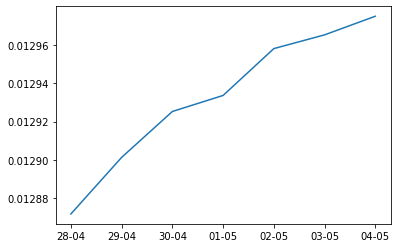

In [8]:
P=Prediction('рубль')
P.prepare_data()
P.predict()
P.make_table()
P.make_png()
P.make_diagram()